In [285]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from itertools import product
import xarray 
import warnings
warnings.filterwarnings('ignore')

def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(*params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def pade4_2(x,A,U1,D1,U2,D2,D3,D4):
    return (U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def order1(x,M1):
    return M1*x/(x-M1*x**2)

def order2(x,M1,M2):
    return (M1*x-M2/2*x**2)/(x-M1*x**2+M2/2*x**3)

def order3(x,M1,M2,M3):
    return (M1*x-M2/2*x**2+M3/6*x**3)/(x-M1*x**2+M2/2*x**3-M3/6*x**4)

def order4(x,M1,M2,M3,M4):
    Tr = 1-M1*x+M2/2*x**2-M3/6*x**3+M4/24*x**4
    return (1-Tr)/(Tr*x)

def order5(x,M1,M2,M3,M4,M5):
    Tr = 1-M1*x+M2/2*x**2-M3/6*x**3+M4/24*x**4-M5/100*x**5
    return (1-Tr)/(Tr*x)

def padeTr4_2(x,A,U1,D1,U2,D2,D3,D4):
    Tr = (U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)
    return (1-Tr)/(Tr*x)

def FrechetLaplace(rs,**kwargs):
    return 2*np.sqrt(rs)*scp.special.kn(1,2*np.sqrt(rs))

def GammaLaplace(rs,k,theta):
    return (1+rs*theta)**(-k)

# General procedure:

1. Exact mean values with different rates are found using: $\langle T\left(r\right) \rangle = \frac{1-\tilde{T}(r)}{r\tilde{T}(r)}$

2. The function $\langle T\left(r\right) \rangle$ is evaluated using different fits to the selected points.

3. The evaluated value at a selected reference point is compared to the exact value at this point.

4. The same process is repeated, using sampled mean values instead of exact values as selected points for the fit.

## Frechet distribution

The selected distribution: $Pr(t) = t^{-2}exp\left(-t^{-1}\right)$.

The mean and standard deviation diverge; we will compare to $\langle T\left(0.001\right) \rangle = 6.8$.

The Laplace transform may be found using the modified Bessel function: $\tilde{T}(r)=2\sqrt{r}K_1\left(2\sqrt{r}\right)$ (https://aip.scitation.org/doi/10.1063/1.4893338).

## Gamma distribution

The selected distribution: $Pr(t) = \frac{1}{\Gamma(k)\theta^k}t^{k-1}exp\left(-\frac{t}{\theta}\right)$.

$\mu = k\theta$, $\sigma = \sqrt{k}\theta$, $\tilde{T}(r)=(1+\theta r)^{-k}$

We chose $k=0.25$, $\theta=25$, which leads to $CV=\frac{\sigma}{\mu}=\frac{1}{\sqrt{k}}=2$

Text(0.75, 9, 'Gamma')

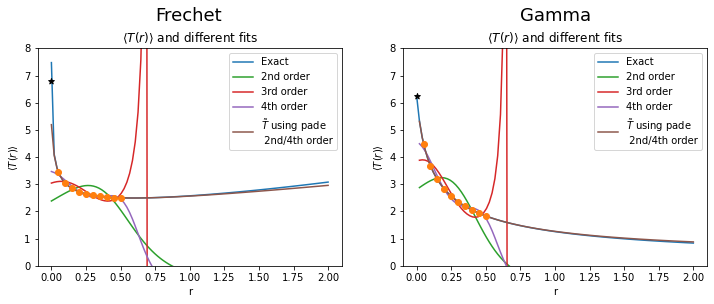

In [286]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
refs = [0.001,0]
TrRef = 2*np.sqrt(refs[0])*scp.special.kn(1,2*np.sqrt(refs[0]))
muRef = [(1-TrRef)/(ref*TrRef),k*theta]
k = 0.25
theta = 25
funcs = [FrechetLaplace,GammaLaplace]
refStarts = [0.0005,0] 

for i in range(2):
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selrs = np.linspace(0.05,0.5,10)
    selTrs = funcs[i](selrs,k=k,theta=theta)
    selmus = (1-selTrs)/(selrs*selTrs)
    axs[i].plot(selrs,selmus,"o",zorder=10)

    # Fits

    for func,label in zip([order2,order3,order4,padeTr4_2],["2nd order","3rd order","4th order",r"$\tilde{T}$"+" using pade \n 2nd/4th order"]):
        fit = scp.optimize.curve_fit(func, selrs, selmus,bounds=(0,np.inf))
        axs[i].plot(rs,func(rs,*fit[0]),label=label)
    axs[i].set_ylim(0,8)
    axs[i].legend()
    axs[i].set_xlabel("r")
    axs[i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[i].set_title(r"$\langle T\left(r\right) \rangle$ and different fits")
axs[0].text(0.75,9,"Frechet",fontsize=18)
axs[1].text(0.75,9,"Gamma",fontsize=18)

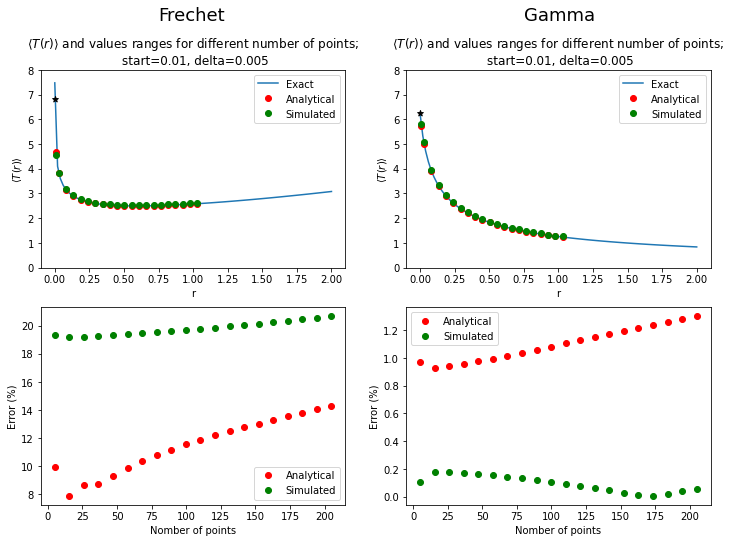

In [287]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
sampleFuncs = [scp.stats.invweibull.rvs,np.random.gamma]
sampleParams = [[1],[k,theta]]
axs[0][0].text(0.75,10,"Frechet",fontsize=18)
axs[0][1].text(0.75,10,"Gamma",fontsize=18)
start = 0.01
delta = 0.005
repeats = 10000
pointslist = np.linspace(5,205,20)

for i in range(2):
    axs[0][i].set_ylim(0,8)
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[0][i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[0][i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selrs = np.array([start]+[start + delta*(p-1) for p in pointslist])
    selTrs = funcs[i](selrs,k=k,theta=theta)
    selmus = (1-selTrs)/(selrs*selTrs)
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="red",label="Analytical")
    axs[0][i].set_xlabel("r")
    axs[0][i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[0][i].set_title(r"$\langle T\left(r\right) \rangle$ and values ranges for different number of points;"+f"\n start={start}, delta={delta}")

    # Simulated

    samples = np.array([sample(sampleFuncs[i],sampleParams[i],start) for j in range(repeats)])
    selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
    selmus = (1-selTrs)/((selrs-start)*selTrs)
    selmus[0] = samples.mean()
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="green",label="Simulated")
    axs[0][i].legend()

    # predictions
    errorsA = []
    errorsS = []
    for points in pointslist:
        selrs = np.linspace(start,start+delta*(points-1),int(points))
        selTrs = funcs[i](selrs,k=k,theta=theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
        pre = padeTr4_2(ref,*fit[0])
        errorsA.append(abs(pre-muRef[i])/muRef[i]*100)
        selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
        selmus = (1-selTrs)/((selrs-start)*selTrs)
        selmus[0] = samples.mean()
        fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
        pre = padeTr4_2(ref,*fit[0])
        errorsS.append(abs(pre-muRef[i])/muRef[i]*100)
    axs[1][i].plot(pointslist,errorsA,"o",c="red",label="Analytical")
    axs[1][i].plot(pointslist,errorsS,"o",c="green",label="Simulated")
    axs[1][i].set_xlabel("Nomber of points")
    axs[1][i].set_ylabel("Error (%)")
    axs[1][i].legend()

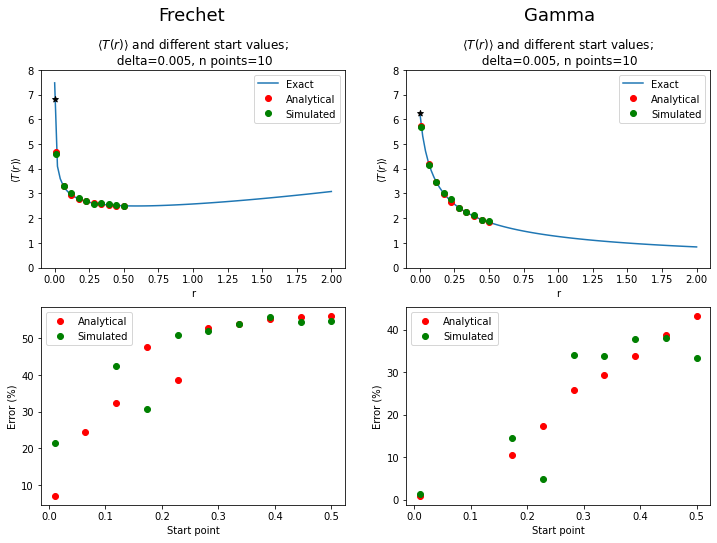

In [288]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0][0].text(0.75,10,"Frechet",fontsize=18)
axs[0][1].text(0.75,10,"Gamma",fontsize=18)
startlist = np.linspace(0.01,0.5,10)
points = 10

for i in range(2):
    axs[0][i].set_ylim(0,8)
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[0][i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[0][i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selTrs = funcs[i](startlist,k=k,theta=theta)
    selmus = (1-selTrs)/(startlist*selTrs)
    axs[0][i].plot(startlist,selmus,"o",zorder=10,c="red",label="Analytical")
    axs[0][i].set_xlabel("r")
    axs[0][i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[0][i].set_title(r"$\langle T\left(r\right) \rangle$ and different start values;"+f"\n delta={delta}, n points={points}")

    # Simulated
    sampleList = []
    for start in startlist:
        sampleList.append(np.array([sample(sampleFuncs[i],sampleParams[i],start) for j in range(repeats)]))
    axs[0][i].plot(startlist,[sample.mean() for sample in sampleList],"o",zorder=10,c="green",label="Simulated")
    axs[0][i].legend()

    # predictions
    errorsA = []
    errorsS = []
    for start,samples in zip(startlist,sampleList):
        selrs = np.linspace(start,start+delta*(points-1),int(points))
        selTrs = funcs[i](selrs,k=k,theta=theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        try:
            fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_2(ref,*fit[0])
        except:
            pre = np.inf 
        errorsA.append(abs(pre-muRef[i])/muRef[i]*100)
        selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
        selmus = (1-selTrs)/((selrs-start)*selTrs)
        selmus[0] = samples.mean()
        try:
            fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_2(ref,*fit[0])
        except:
            pre = np.inf 
        errorsS.append(abs(pre-muRef[i])/muRef[i]*100)
    axs[1][i].plot(startlist,errorsA,"o",c="red",label="Analytical")
    axs[1][i].plot(startlist,errorsS,"o",c="green",label="Simulated")
    axs[1][i].set_xlabel("Start point")
    axs[1][i].set_ylabel("Error (%)")
    axs[1][i].legend()

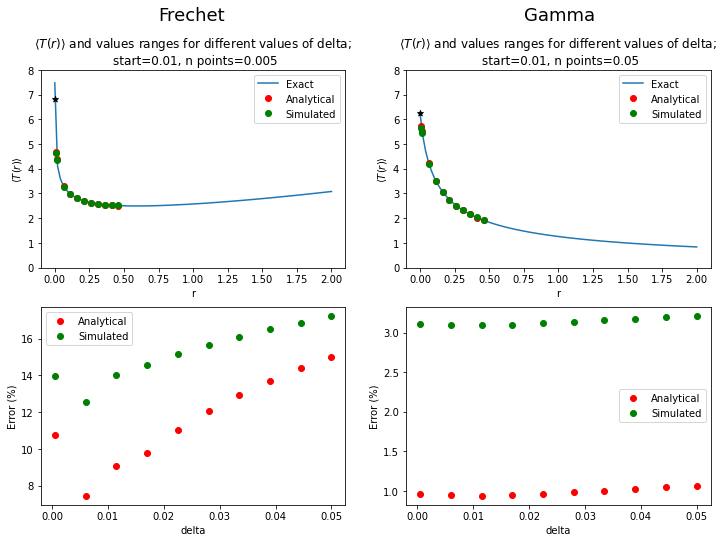

In [291]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0][0].text(0.75,10,"Frechet",fontsize=18)
axs[0][1].text(0.75,10,"Gamma",fontsize=18)
start = 0.01
deltalist = np.linspace(0.0005,0.05,10)
repeats = 10000

for i in range(2):
    axs[0][i].set_ylim(0,8)
    
    # Exact solutions

    rs = np.linspace(refStarts[i],2,100)
    Trs = funcs[i](rs,k=k,theta=theta)
    mus = (1-Trs)/(rs*Trs)
    if i==1:
        mus[0] = k*theta
    axs[0][i].plot(rs,mus,label="Exact")

    # Reference
    
    axs[0][i].scatter(refs[i],muRef[i],c="black",marker="*",zorder=10)

    # Selected example

    selrs = np.array([start]+[start + delta*9 for delta in deltalist])
    selTrs = funcs[i](selrs,k=k,theta=theta)
    selmus = (1-selTrs)/(selrs*selTrs)
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="red",label="Analytical")
    axs[0][i].set_xlabel("r")
    axs[0][i].set_ylabel(r"$\langle T\left(r\right) \rangle$")
    axs[0][i].set_title(r"$\langle T\left(r\right) \rangle$ and values ranges for different values of delta;"+f"\n start={start}, n points={delta}")

    # Simulated

    samples = np.array([sample(sampleFuncs[i],sampleParams[i],start) for j in range(repeats)])
    selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
    selmus = (1-selTrs)/((selrs-start)*selTrs)
    selmus[0] = samples.mean()
    axs[0][i].plot(selrs,selmus,"o",zorder=10,c="green",label="Simulated")
    axs[0][i].legend()

    # predictions
    errorsA = []
    errorsS = []
    for delta in deltalist:
        selrs = np.linspace(start,start+delta*(points-1),int(points))
        selTrs = funcs[i](selrs,k=k,theta=theta)
        selmus = (1-selTrs)/(selrs*selTrs)
        try:
            fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_2(ref,*fit[0])
        except:
            pre = np.inf 
        errorsA.append(abs(pre-muRef[i])/muRef[i]*100)
        selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
        selmus = (1-selTrs)/((selrs-start)*selTrs)
        selmus[0] = samples.mean()
        try:
            fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
            pre = padeTr4_2(ref,*fit[0])
        except:
            pre = np.inf 
        errorsS.append(abs(pre-muRef[i])/muRef[i]*100)
    axs[1][i].plot(deltalist,errorsA,"o",c="red",label="Analytical")
    axs[1][i].plot(deltalist,errorsS,"o",c="green",label="Simulated")
    axs[1][i].set_xlabel("delta")
    axs[1][i].set_ylabel("Error (%)")
    axs[1][i].legend()

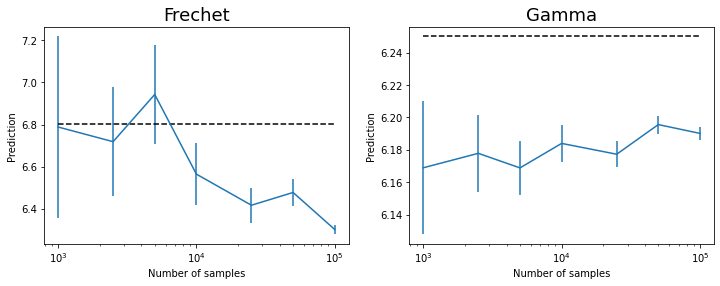

In [290]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title("Frechet",fontsize=18)
axs[1].set_title("Gamma",fontsize=18)

start = 0.01
points = 10
delta = 0.005
repeatList = [1000,2500,5000,10000,25000,50000,100000]
selrs = np.linspace(start,start+delta*(points-1),int(points))
for i in range(2):
    predictions = []
    errors = []
    for repeats in repeatList:
        pres = []
        for j in range(100):
            samples = np.array([sample(sampleFuncs[i],sampleParams[i],start) for k in range(repeats)])
            selTrs = np.array([sum(np.exp(-r*samples))/repeats for r in selrs-start])
            selmus = (1-selTrs)/((selrs-start)*selTrs)
            selmus[0] = samples.mean()
            try:
                fit = scp.optimize.curve_fit(padeTr4_2, selrs, selmus,bounds=(0,np.inf))
                pre = padeTr4_2(ref,*fit[0])
                pres.append(pre)
            except:
                pass
        predictions.append(np.mean(pres))
        errors.append(np.std(pres)/np.sqrt(len(pres)))
    axs[i].errorbar(repeatList,predictions,errors)
    axs[i].plot([min(repeatList),max(repeatList)],[muRef[i],muRef[i]],c="black",linestyle="dashed")
    axs[i].set_xscale("log")
    axs[i].set_xlabel("Number of samples")
    axs[i].set_ylabel("Prediction")